<a href="https://colab.research.google.com/github/GabrielaSchmitt/CereBroto/blob/main/Vegetais_classificador_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Para sincronizar a pasta do drive onde fizemos o download do dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 3000 validated image filenames belonging to 15 classes.
Found 15010 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/5
94/94 [==============================] - 1571s 17s/step - loss: 0.4353 - accuracy: 0.8893 - val_loss: 0.0474 - val_accuracy: 0.9873
Epoch 2/5
94/94 [==============================] - 281s 3s/step - loss: 0.0270 - accuracy: 0.9930 - val_loss: 0.0319 - val_accuracy: 0.9917
Epoch 3/5
94/94 [==============================] - 234s 2s/step - loss: 0.0078 - accuracy: 0.9987 - val_loss: 0.0198 - val_accuracy: 0.9947
Epoch 4/5
94/94 [==============================] - 241s 3s/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0158 - val_accuracy: 0.9963
Epoch 5/5
470/470 [==============================] - 3924s 8s/step
Acurácia no conjunto de teste: 6.82%


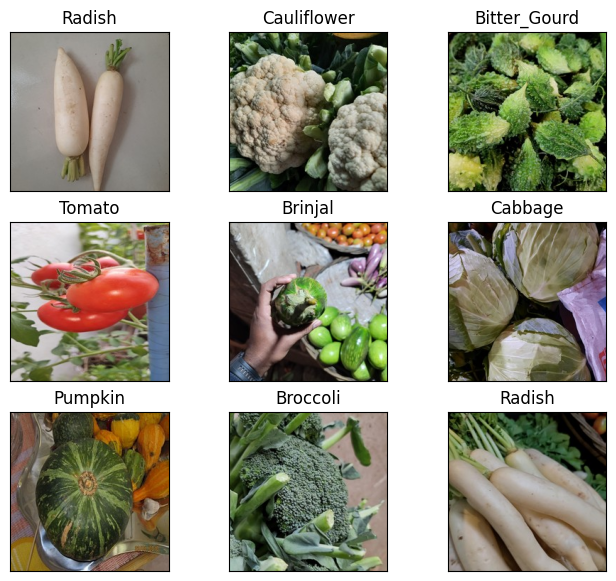

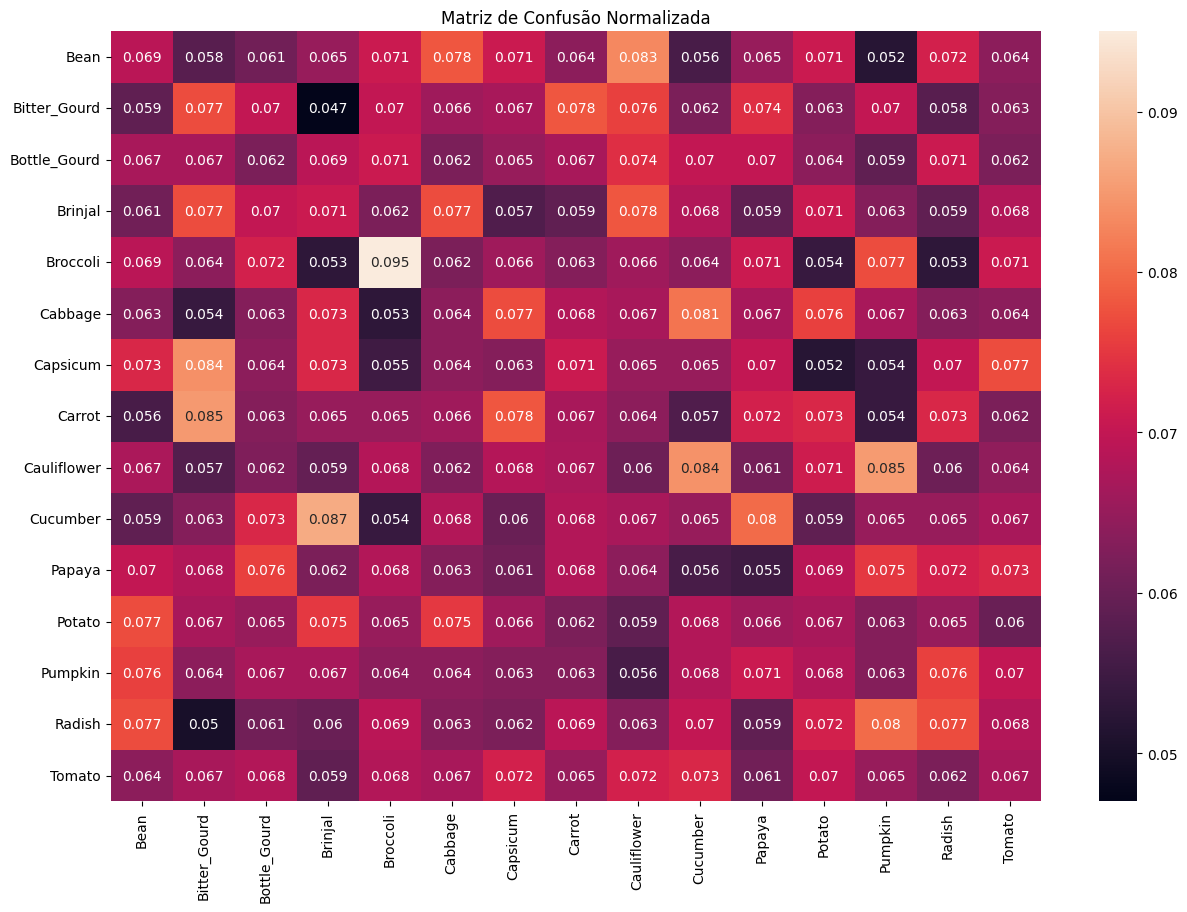

<ipython-input-2-e755a5354be6>:142: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Grad-CAM salvo em: cam.jpg


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.cm as cm

def carregar_caminhos_dos_arquivos(diretorio):
    return list(Path(diretorio).glob(r'**/*.jpg'))

def processar_imagem(caminho_arquivo):
    etiquetas = [str(caminho_arquivo[i]).split("/")[-2] for i in range(len(caminho_arquivo))]
    caminho_arquivo = pd.Series(caminho_arquivo, name='Caminho').astype(str)
    etiquetas = pd.Series(etiquetas, name='Etiqueta')
    df = pd.concat([caminho_arquivo, etiquetas], axis=1)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

def exibir_imagens(df):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 7), subplot_kw={'xticks': [], 'yticks': []})
    num_imagens = len(df)
    num_subplot = len(axes.flat)
    if num_imagens >= num_subplot:
        for i, ax in enumerate(axes.flat):
            ax.imshow(plt.imread(df.Caminho[i]))
            ax.set_title(df.Etiqueta[i], fontsize=12)
    else:
        print("O número de imagens é menor do que o número de subplots. Não é possível exibir todas as imagens.")

def gerar_gerador_de_imagens(df, preprocessing_function=None):
    return tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=preprocessing_function
    ).flow_from_dataframe(
        dataframe=df,
        x_col='Caminho',
        y_col='Etiqueta',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

def construir_modelo(input_shape=(224, 224, 3), num_classes=15):
    modelo_pre_treinado = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    modelo_pre_treinado.trainable = False

    x = tf.keras.layers.Dense(128, activation='relu')(modelo_pre_treinado.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    modelo = tf.keras.Model(inputs=modelo_pre_treinado.input, outputs=outputs)
    modelo.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return modelo

def treinar_modelo(modelo, train_generator, val_generator, epochs=5):
    history = modelo.fit(
        train_generator,
        validation_data=val_generator,
        batch_size=32,
        epochs=epochs,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=2,
                restore_best_weights=True
            )
        ]
    )
    return history

def avaliar_modelo(modelo, test_generator):
    pred = modelo.predict(test_generator)
    pred = np.argmax(pred, axis=1)
    labels = test_generator.class_indices
    labels = dict((v, k) for k, v in labels.items())
    pred = [labels[k] for k in pred]
    y_test = [labels[k] for k in test_generator.classes]
    acc = accuracy_score(y_test, pred)
    print(f'Acurácia no conjunto de teste: {100*acc:.2f}%')

    cf_matrix = confusion_matrix(y_test, pred, normalize='true')
    plt.figure(figsize=(15,10))
    sns.heatmap(cf_matrix,
                annot=True,
                xticklabels=sorted(set(y_test)),
                yticklabels=sorted(set(y_test)),
                )
    plt.title('Matriz de Confusão Normalizada')
    plt.show()

    return pred, y_test

def obter_array_img(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def gerar_mapa_calor_gradcam(array_img, modelo, last_conv_layer_name=None, pred_index=None):
    grad_model = tf.keras.models.Model(
        [modelo.inputs], [modelo.get_layer(last_conv_layer_name).output, modelo.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(array_img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = last_conv_layer_output[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def salvar_e_exibir_gradcam(img_path, heatmap, caminho_saida="cam.jpg", alpha=0.4):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    heatmap_jet = jet_colors[heatmap]
    heatmap_jet = tf.keras.preprocessing.image.array_to_img(heatmap_jet)
    heatmap_jet = heatmap_jet.resize((img.shape[1], img.shape[0]))
    heatmap_jet = tf.keras.preprocessing.image.img_to_array(heatmap_jet)
    img_superposta = heatmap_jet * alpha + img
    img_superposta = tf.keras.preprocessing.image.array_to_img(img_superposta)
    img_superposta.save(caminho_saida)
    return caminho_saida

def main():
    train_dir = '/content/drive/MyDrive/Vegetable_Dataset/Vegetable Images/test'
    test_dir = '/content/drive/MyDrive/Vegetable_Dataset/Vegetable Images/train'
    val_dir = '/content/drive/MyDrive/Vegetable_Dataset/Vegetable Images/validation'

    train_filepaths = carregar_caminhos_dos_arquivos(train_dir)
    test_filepaths = carregar_caminhos_dos_arquivos(test_dir)
    val_filepaths = carregar_caminhos_dos_arquivos(val_dir)

    train_df = processar_imagem(train_filepaths)
    test_df = processar_imagem(test_filepaths)
    val_df = processar_imagem(val_filepaths)

    exibir_imagens(train_df)

    train_generator = gerar_gerador_de_imagens(train_df, preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
    test_generator = gerar_gerador_de_imagens(test_df, preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
    val_generator = gerar_gerador_de_imagens(val_df, preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

    modelo = construir_modelo()
    history = treinar_modelo(modelo, train_generator, val_generator, epochs=5)

    pred, y_test = avaliar_modelo(modelo, test_generator)

    location = '/content/drive/MyDrive/Vegetable_Dataset/Vegetable Images/test/Cabbage/1196.jpg'
    img_array = obter_array_img(location, size=(224, 224, 3))
    heatmap = gerar_mapa_calor_gradcam(img_array, modelo, last_conv_layer_name="Conv_1")
    caminho_saida = salvar_e_exibir_gradcam(location, heatmap)
    print(f'Grad-CAM salvo em: {caminho_saida}')

    modelo.save('ModeloVegetais.h5')

if __name__ == "__main__":
    main()
